### Generation of arrays using trap

In [1]:
from microfluidics_ipkiss3.technology import * #comment when running main script, uncomment to debug geometry
from ipkiss3 import all as i3
import microfluidics_ipkiss3.all as microfluidics

import sys
sys.path.append("../..")   #adding higher directory

from components.trap import CellTrapSimple
from components.tee import TeeSimple
from components.trap_with_tees import TrapWithTees


# PCell containing several traps
class CircuitOfBlocks(microfluidics.PlaceAndAutoRoute):
    """Parametric cell with several traps, which are stacked vertically (Parallel) or horizontally (Series)
    """
    #_name_prefix = "circuitOfTraps"
    type = i3.NumberProperty(default = 0) #  0 Paralell 1 Series
    block_distance = i3.NumberProperty(default = 400.) #distance betwn traps
    block_with_tee = i3.ChildCellListProperty() #  Generating traps with Tee from Child Cell List Property
    trace_template = microfluidics.ChannelTemplateProperty(default=microfluidics.ShortChannelTemplate())
    n_blocks_x = i3.PositiveIntProperty(default = 30)
    n_blocks_y = i3.PositiveIntProperty(default = 30)
    x_footprint = i3.PositiveIntProperty(default = 1000)
    y_footprint = i3.PositiveIntProperty(default = 1000)

    def _default_child_cells(self):
        return {"blk_w_tee{}".format(cnt) : self.block_with_tee[cnt]
                for cnt in range(self.n_blocks_x*self.n_blocks_y)}


    def _default_links(self):
        links = []
        bx = self.n_blocks_x

        ########################
        #############   PARALLEL
        if self.type == 0:
            for cntx in range(0, self.n_blocks_x):
                # self connection at the top -bypass
                top = self.n_blocks_y * self.n_blocks_x - self.n_blocks_x + cntx
                links.append(("blk_w_tee{}:in2".format(top),"blk_w_tee{}:out2".format(top)))
                # connecting bottom to top
                for cnty in range(0, self.n_blocks_y-1):
                    links.append(("blk_w_tee{}:in2".format(cnty*bx+cntx), "blk_w_tee{}:in1".format((cnty+1)*bx+cntx)))
                    links.append(("blk_w_tee{}:out2".format(cnty*bx+cntx), "blk_w_tee{}:out1".format((cnty+1)*bx+cntx)))

            #interconnecting horizontally
            if self.n_blocks_x > 1:
                for cntd in range(0, self.n_blocks_x-1):
                    links.append(("blk_w_tee{}:out1".format(cntd), "blk_w_tee{}:in1".format(cntd+1)))
        ########  END PARALLEL #################

        ########################
        #############   SERIES
        if self.type == 1:             # series
            #all by-pass, each object
            for cnt in range(0, self.n_blocks_y*self.n_blocks_x): #all bypass
                links.append(("blk_w_tee{}:in2".format(cnt), "blk_w_tee{}:out2".format(cnt)))

            #all interconnecting horizontally
            if self.n_blocks_x > 1:
                for cnty in range(0, self.n_blocks_y):
                 for cntd in range(0, (self.n_blocks_x-1)):
                    links.append(("blk_w_tee{}:out1".format(cnty*bx+cntd), "blk_w_tee{}:in1".format(cnty*bx+cntd+1)))

            #left connections
            for cntd in range(1, (self.n_blocks_y-1),2):
                #links.append(("blk_w_tee{}:in1".format(cntd * bx), "blk_w_tee{}:in1".format((cntd+1) * bx)))
                links.append(("blk_w_tee{}:in1".format((cntd+1) * bx), "blk_w_tee{}:in1".format(cntd * bx)))

            #right connections
            for cntd in range(1, (self.n_blocks_y),2):
                links.append(("blk_w_tee{}:out1".format(cntd * bx-1), "blk_w_tee{}:out1".format((cntd+1) * bx-1)))

        ########  END SERIES #################

        return links




    def _default_block_with_tee(self):  # Generating traps from Child Cell List Property
        tee1 = TeeSimple()
        tee1.Layout(tee_length=(200.0))
        my_block = CellTrapSimple()
        my_block.Layout(cell_trap_length= 300.0)
        return [TrapWithTees(name="blk_w_tee_{}".format(cnt),
                             trap=my_block,
                             tee=tee1,
                             )
                for cnt in range(self.n_blocks_x*self.n_blocks_y)]

    class Layout(microfluidics.PlaceAndAutoRoute.Layout):

        def _default_child_transformations(self):

            # generate grid
            x = np.linspace(0, self.cell.x_footprint, self.cell.n_blocks_x)
            y = np.linspace(0, self.cell.y_footprint, self.cell.n_blocks_y)

            # generate positions
            from functions.position_coordinates import generate_positions
            coords = generate_positions(x, y, self.type)

            return {"blk_w_tee{}".format(cnt): i3.Translation(coords[cnt])
                 for cnt in range(self.n_blocks_x*self.n_blocks_y)}

        def _generate_ports(self, ports):
            # Add ports
            if self.type == 0:
                ports += i3.expose_ports(self.instances,{
                    'blk_w_tee0:in1': 'in1',
                    'blk_w_tee{}:out1'.format(self.n_blocks_x-1): 'out1'
                })

            if self.type == 1:
                if self.n_blocks_y %2 == 0:
                    ports += i3.expose_ports(self.instances,{
                    'blk_w_tee0:in1': 'in1',
                    'blk_w_tee{}:in1'.format(self.n_blocks_x*self.n_blocks_y-self.n_blocks_x): 'out1' # last left
                })
                else:
                    ports += i3.expose_ports(self.instances, {
                        'blk_w_tee0:in1': 'in1',
                        'blk_w_tee{}:out1'.format(self.n_blocks_x*self.n_blocks_y - 1): 'out1'  # last right
                    })

            return ports

### Array determined by:
n_traps_x and n_traps_y

x footprint
y footprint

In [11]:
if __name__ == "__main__":
    print "This is not the main file. Run 'execute.py' in the same folder"
    import numpy as np
    sys.path.append("../..")  # adding higher directory to include basic components (block, trap, tee)
    sys.path.append("..")     # adding higher directory to include function to generate array (series, par, spiral)
    
    x_footp = 2500 #foot print of array on X
    y_footp = 2500 #foot print of array on Y
    n_traps_x= 2
    n_traps_y = 2

    myCircuiTrap = CircuitOfBlocks(name = "circuitOfTraps",
                             n_blocks_x = n_traps_x,
                             n_blocks_y = n_traps_y,
                             x_footprint = x_footp,
                             y_footprint = y_footp,
                             type= 1 # 0 Paralell, 1 Series
                          )
    myCircuiTrap_layout = myCircuiTrap.Layout(bend_radius =200)
    myCircuiTrap_layout.visualize(annotate = True)

This is not the main file. Run 'execute.py' in the same folder


# Parallel array of x= 2  y = 2


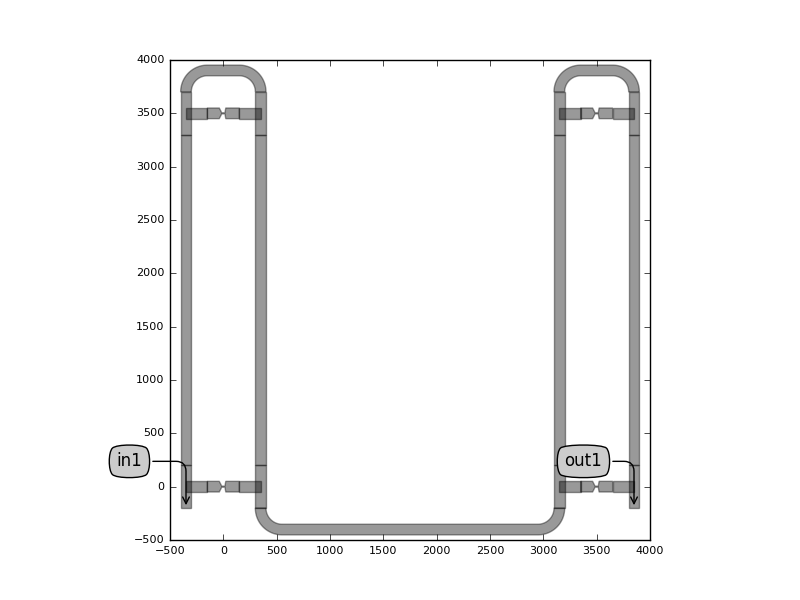

In [12]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "files/array_2x2_parallel_trap.png", width = 600, height = 300)

# Parallel array of x= 4  y = 10

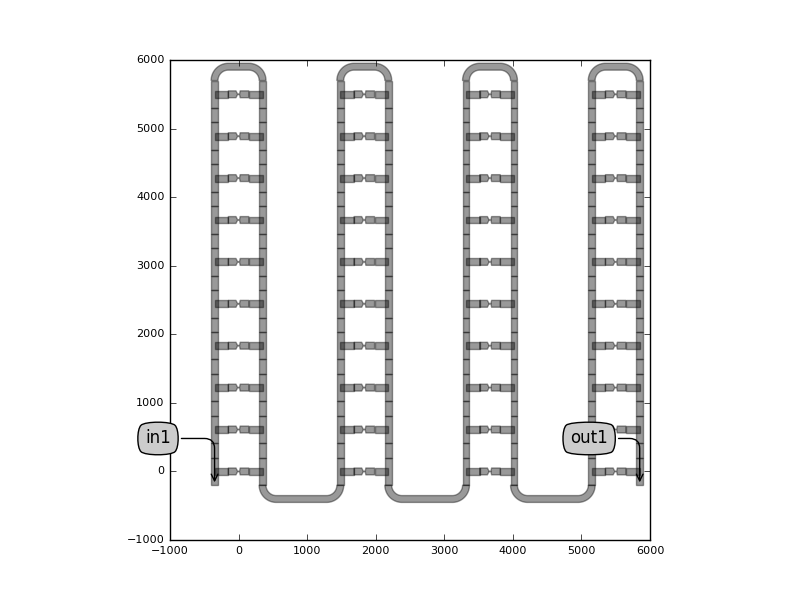

In [13]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "files/array_4x10_parallel_trap.png", width = 600, height = 300)

# series x = 2, y = 2

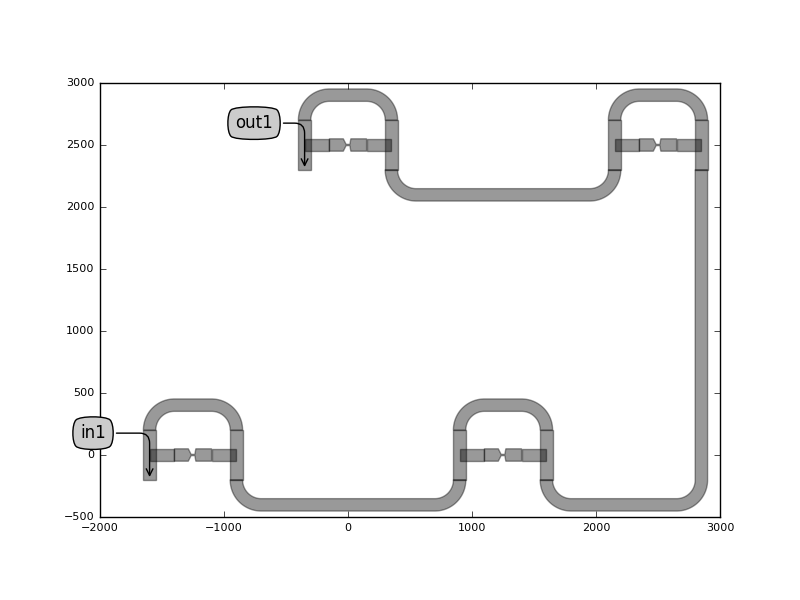

In [14]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "files/array_2x2_series_trap.png", width = 600, height = 300)

## Series x = 4  y = 10

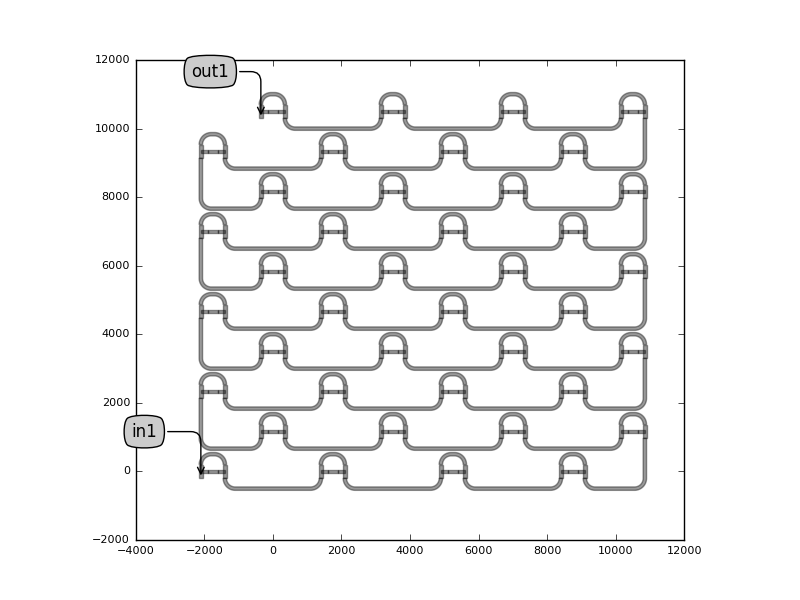

In [15]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "files/array_4x10_series.png", width = 600, height = 300)

## STL Generation Throught OpenFOAM engine

In [16]:
if __name__ == "__main__":
    print "This is not the main file. Run 'execute.py' in the same folder"
    #generating STL and OF sim
    
    from microfluidics_ipkiss3.pysimul.openfoam.openfoam_engine import *
    from microfluidics_ipkiss3.pysimul.openfoam.turbulence_model import *
    from microfluidics_ipkiss3.pysimul.openfoam.transport_model import *

    # Control how the mesh is generated

    snap_control = SnapControl(num_smooth_patch=1)
    add_layer_control = AddLayerControl(final_layer_thickness=10, min_thickness=1, num_grow=10)
    mesh_quality_control = MeshQualityControl(max_non_orthogonal=90)
    mesh_control = MeshControl(mesh_size=20, feature_refinement_level=2,
                               surface_refinement_level=(1, 2),
                               refinement_regions=[(1, 2)],
                               snap_mesh=True, snap_control=snap_control,
                               add_layer=True, add_layer_control=add_layer_control,
                               mesh_quality_control=mesh_quality_control)

    # Transport and turbulence models

    transport_model = NewtonianModel(kinematic_viscosity=0.00345 / 1050)
    turbulence_model = LaminarModel()

    # Create a list of properties required by simpleFoam solver including the transport property
    # and a list of properties returned by turbulenace model

    properties = [transport_model.get_model_property()] + turbulence_model.get_model_properties()

    # Initialise the engine with simpleFoam solver

    engine = OpenFoamEngine(mesh_control=mesh_control, solver='simpleFoam',
                            properties=properties)

    from microfluidics_ipkiss3.pysimul.runtime.basic import *

    params = dict()
    params["engine"] = engine
    params["inlets"] = [FixedVelocityInlet(in_port_number=0, velocity=(0.0, 50.0e-3, 0))
                         ]

    window_si = SizeInfo(west=-260, east=260, south=-360, north=360)
    #params["window_size_info"] = window_si

    # 2D simulation
    params["dimensions"] = 2  #can be 3 for 3D

    # Create and run simulation

    from ipkiss.plugins.simulation import *

    simul = myCircuiTrap_layout.create_simulation(simul_params=params)

    # Start running simulation

    simul.procedure.run(case_name='block2x4_round', use_existing_mesh=False, interactive=True)
    

This is not the main file. Run 'execute.py' in the same folder


Finish generating mesh.

Final mesh is in block2x4_round/constant/polyMesh

Exiting...


SystemExit: 0

/home/fran/anaconda2/envs/ipkiss3/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### STL generation

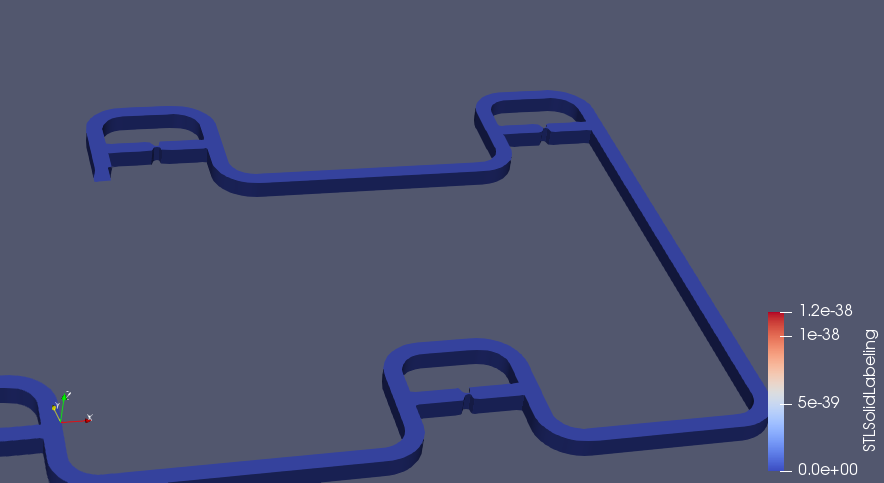

In [17]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "files/array_2x2_series_stl_trap.png", width = 600, height = 300)

### Mesh

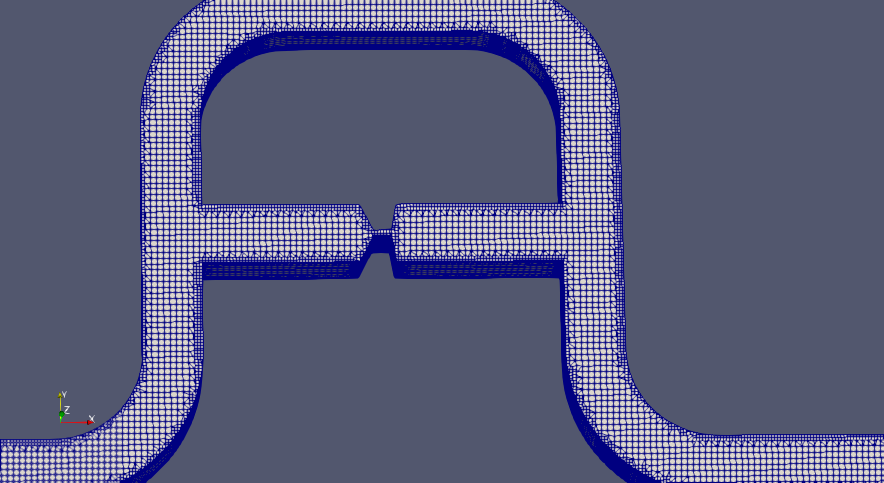

In [18]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "files/array_2x2_series_mesh_trap.png", width = 600, height = 300)

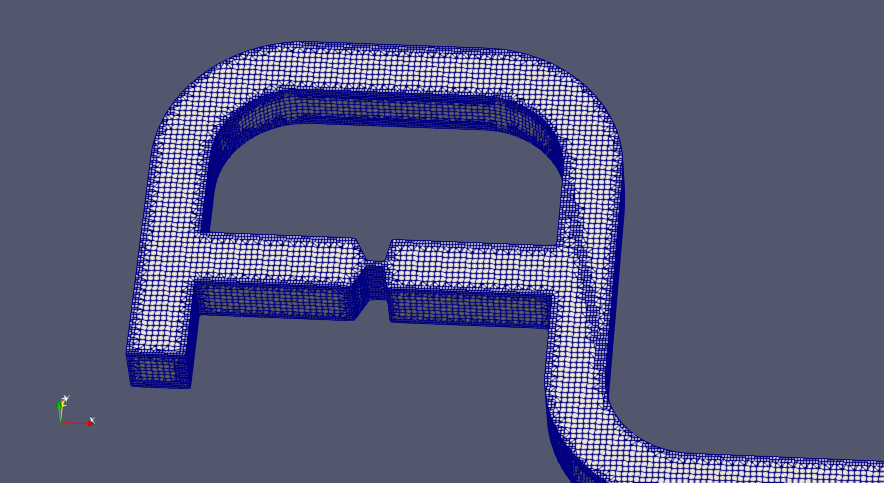

In [19]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "files/array_2x2_series_mesh_trap2.png", width = 600, height = 300)

### CFD pressure

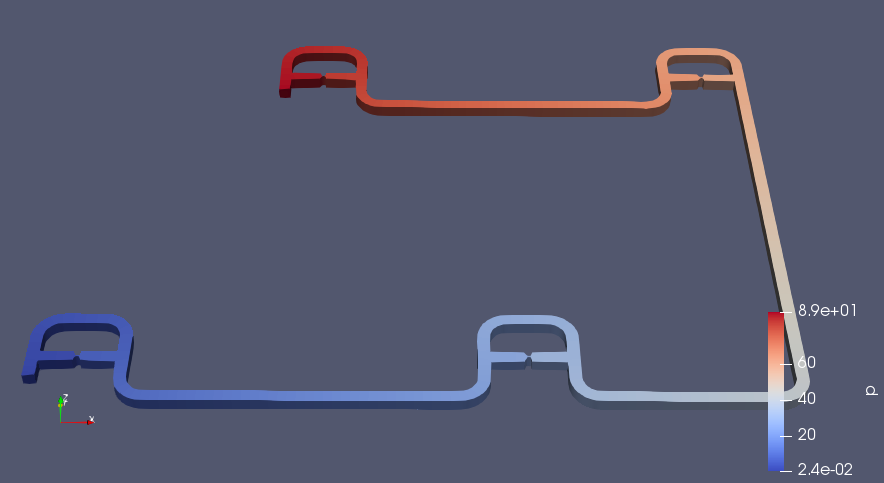

In [20]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "files/array_2x2_series_pressure_trap.png", width = 600, height = 300)

### CFD velocity

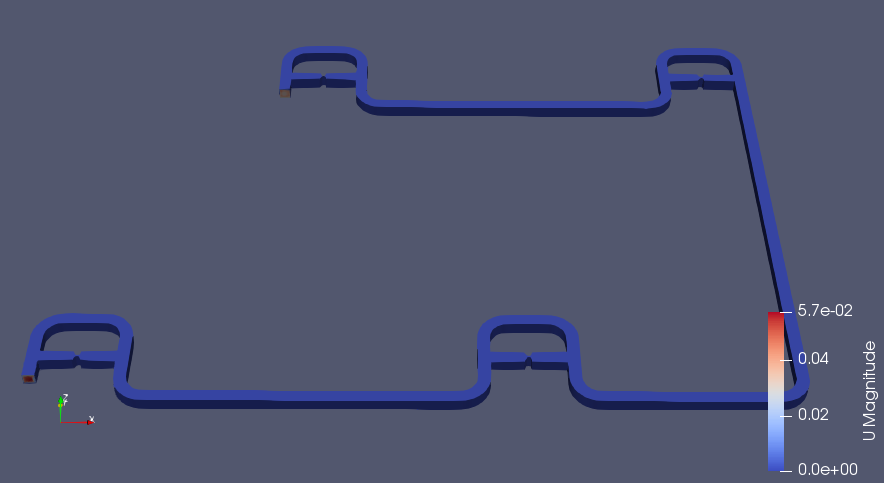

In [21]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "files/array_2x2_series_vel_trap.png", width = 600, height = 300)

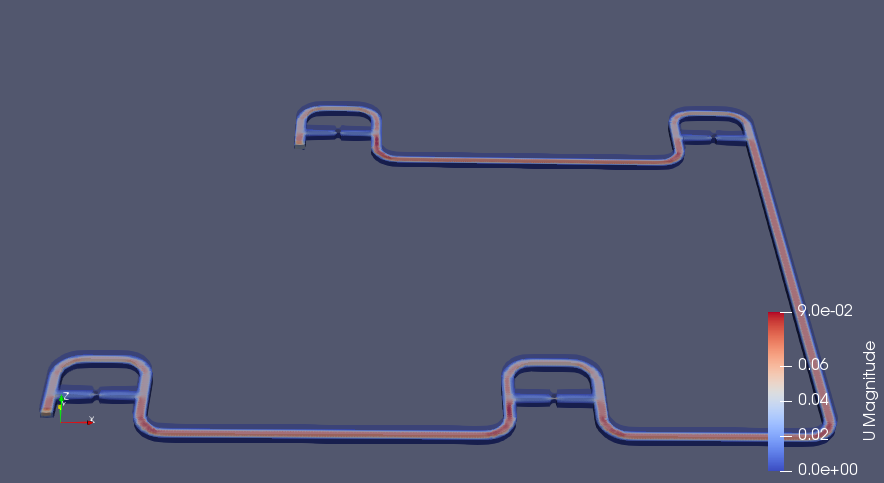

In [22]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "files/array_2x2_series_vel_trap_transp.png", width = 600, height = 300)

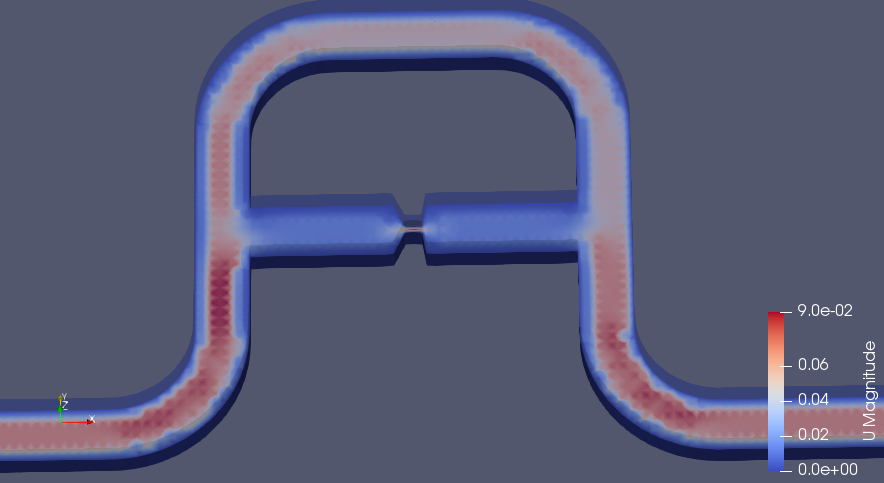

In [23]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "files/array_2x2_series_vel_trap_transp_zoomin.png", width = 600, height = 300)